## Music Merlin Classifier 🧙‍♂️
**Genre Classification for Spotify Songs**

The goal of this project is to use supervised learning to classify a track based on its features into 1 of 6 genres: Pop, Hip-Hop/Rap, Alt/Indie, Rock, Jazz, and Classical.

### Imports 📃

In [1]:
import spotipy
import pandas as pd
import numpy as np
import os
import datetime as dt
from spotipy.oauth2 import SpotifyOAuth
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from collections import namedtuple

### Data Extraction 💾

We can pull data from playlists curated to each genre, and label each sample according to which genre of playlist it was pulled from. For example, training data from the `POP` class will come from playlists in the `POP` genre below.

In [2]:
Playlist = namedtuple('Playlist', ['username', 'playlist_id'])

POP = 'Pop'
HIP_HOP = 'Hip-Hop-Rap'
ALT_IND = 'Alt-Indie'
ROCK = 'Rock'
JAZZ = 'Jazz'
CLASSICAL = 'Classical'

GENRES = {
    POP: [
        Playlist('spotify', '37i9dQZF1DXcOFePJj4Rgb'),
        Playlist('spotify', '37i9dQZF1DXarRysLJmuju'),
        Playlist('spotify', '37i9dQZF1DX2L0iB23Enbq'),
        Playlist('spotify', '37i9dQZF1DXcRXFNfZr7Tp')
    ],
    HIP_HOP: [
        Playlist('spotify', '37i9dQZF1DWY6tYEFs22tT'),
        Playlist('spotify', '37i9dQZF1DX0XUsuxWHRQd'),
        Playlist('spotify', '37i9dQZF1DX48TTZL62Yht'),
        Playlist('spotify', '37i9dQZF1DX9oh43oAzkyx')
    ],
    ALT_IND: [
        Playlist('spotify', '37i9dQZF1DX9GRpeH4CL0S'),
        Playlist('spotify', '37i9dQZF1DWZP6bJtKFz1V'),
        Playlist('spotify', '37i9dQZF1DX26DKvjp0s9M'),
        Playlist('spotify', '37i9dQZF1DXcZ6y0ulQ9Gz')
    ],
    ROCK: [
        Playlist('spotify', '37i9dQZF1DWXRqgorJj26U'),
        Playlist('spotify', '37i9dQZF1DX11ghcIxjcjE'),
        Playlist('spotify', '37i9dQZF1DWWOaP4H0w5b0'),
        Playlist('spotify', '37i9dQZF1DWWRktbhJiuqL')
    ],
    JAZZ: [
        Playlist('spotify', '37i9dQZF1DXbITWG1ZJKYt'),
        Playlist('spotify', '37i9dQZF1DWXSyfX6gqDNp'),
        Playlist('spotify', '37i9dQZF1DXdwTUxmGKrdN'),
        Playlist('spotify', '37i9dQZF1DWVfUtaeUAwqa')          
    ],
    CLASSICAL: [
        Playlist('spotify', '37i9dQZF1DWWEJlAGA9gs0'),
        Playlist('peacefulclassics', '1h0CEZCm6IbFTbxThn6Xcs'),
        Playlist('spotify', '37i9dQZF1DX7dzHXrANAir'),
        Playlist('wijayadriansyah', '2bKGFDfzL8eD9XgH4IsQPC'),
    ]
}

GENRE_MAPPINGS = {
    POP: 0,
    HIP_HOP: 1,
    ALT_IND: 2,
    ROCK: 3,
    JAZZ: 4,
    CLASSICAL: 5
}

The following class allows us to quickly and easily download the data we need into CSV files.

Note, you will need to obtain a `CLIENT_ID` and `CLIENT_SECRET` from [Spotify](https://developer.spotify.com/dashboard/login), and add these to your environment variables. This is to access the Spotify API.

In [3]:
class PlaylistDataDownloader:
    
    def __init__(self, genres):
        self.client_id = os.environ['CLIENT_ID']
        self.client_secret = os.environ['CLIENT_SECRET']
        self.redirect_uri = 'http://localhost:8080/'
        self.scope = 'user-library-read'
        self.sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=self.scope, client_id=self.client_id, client_secret=self.client_secret, redirect_uri=self.redirect_uri))
        self.genres = genres
    
    def get_playlist_tracks_in_batches(self, results):
        batches = []
        while True:
            is_last_batch = (results['next'] == None)
            batches.append(results['items'])
            if is_last_batch:
                break;
            else:
                results = self.sp.next(results)
                
        return batches
    
    def download_playlist_data(self, playlist):
        results = self.sp.user_playlist_tracks(playlist.username, playlist.playlist_id)
        batches = self.get_playlist_tracks_in_batches(results)
              
        data = {
            'title': [], 'artists': [], 'album': [], 'duration_ms': [], 'release_date': [], 'artist_genres': [], 'explicit': [], 'popularity': [], 
            'danceability': [], 'energy': [], 'key': [], 'loudness': [], 'mode': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [],
            'liveness': [], 'valence': [], 'tempo': [], 'time_signature': [], 'uri': []
        }

        for batch in batches:

            # Get basic features for a batch
            for item in batch:

                track = item['track']
                artists = track['artists']
                album = track['album']

                # title
                data['title'].append(track['name'])
                # artists
                data['artists'].append(', '.join([artist['name'] for artist in artists]))
                # album
                data['album'].append(album['name'])
                # release_date
                data['release_date'].append(pd.to_datetime(album['release_date']))
                # artist_genres
                artist_genres = []
                for artist in artists:
                    genres = self.sp.artist(artist['external_urls']['spotify'])['genres']
                    artist_genres += genres
                artist_genres = ', '.join(set(artist_genres))
                data['artist_genres'].append(artist_genres)
                # explicit
                data['explicit'].append(track['explicit'])
                # popularity
                data['popularity'].append(track['popularity'])

            # Get more advanced audio features for a batch
            uris = [item['track']['uri'] for item in batch]
            track_features = self.sp.audio_features(uris)
            for features in track_features:
                keys = ['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
                        'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'uri']
                for key in keys:
                    data[key].append(features[key])

        return pd.DataFrame(data=data, index=range(len(data['uri'])), columns=data.keys())
    
    def download_genre_data(self):
        for genre in self.genres:
            genre_df = pd.DataFrame()
            for playlist in self.genres[genre]:
                playlist_df = self.download_playlist_data(playlist)
                genre_df = pd.concat([genre_df, playlist_df], ignore_index=True)
            genre_df['genre'] = [genre for _ in range(len(genre_df))]
            genre_df.to_csv(f'Data/{genre}.csv')

The below code can be commented out once the data has been downloaded.

In [1]:
# downloader = PlaylistDataDownloader(GENRES)
# downloader.download_genre_data()

Once downloaded, we can combine the data from all genres, and remove tracks that come from different playlists within a genre, but have the same title and artist, as these are duplicates that could artificially skew the data.

In [5]:
track_df = pd.DataFrame()
for genre in GENRES:
    genre_df = pd.read_csv(f'Data/{genre}.csv')
    genre_df = genre_df.sort_values('popularity', ascending=False).drop_duplicates(subset=['title', 'artists'])
    track_df = pd.concat([track_df, genre_df], ignore_index=True)

Finally, we do a bit of feature engineering to deal with null values, dates, boolean values, and our categorical target value `genre`.

In [6]:
track_df = track_df.drop(track_df.columns[0], axis=1)                                                                                # Remove redundant index column
track_df['release_date'] = track_df['release_date'].apply(lambda release_date: abs(dt.datetime.now().year - int(release_date[0:4]))) # Convert date to years since release
track_df = track_df.rename(columns={'release_date': 'years_since_release'})
track_df['explicit'] = track_df['explicit'].astype(int)                                                                              # Convert 'explicit' from boolean to int
track_df['genre'] = track_df['genre'].apply(lambda genre: GENRE_MAPPINGS[genre])                                                     # Convert 'genre' from string to int
track_df = track_df.dropna()

### Train/Test Split ✂

We immediately split train/test data to ensure we do not taint the test set. We use a random stratified split to ensure even distribution of target classes between train and test.

In [7]:
drop_features = ['title', 'artists', 'album', 'uri']
text_feature = 'artist_genres'
scale_features = ['duration_ms', 'years_since_release', 'popularity',
                  'danceability', 'energy', 'loudness', 'speechiness',
                  'acousticness', 'instrumentalness', 'liveness',
                  'valence', 'tempo']
passthrough_features = ['explicit', 'key', 'mode', 'time_signature']

X = track_df.drop(columns=drop_features + ['genre'])
y = track_df['genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True, stratify=y)

### Exploratory Analysis 🔍

We can now conduct exploratory data analysis on our input, `X_train`.

#### Features
Our input features are:
* `duration_ms`: Duration of the track, in milliseconds
* `years_since_release`: Years since track was released
* `artist_genres`: List of genres associated with the artist
* `explicit`: Whether the song is explicit or not
* `popularity`: How popular the song is, \[0 - 100\]
* `danceability`: How suitable a track is for dancing, \[0 - 1\]
* `energy`: How energetic a track is, \[0 - 1\]
* `key`: Key of the track
* `loudness`: How loud the track is, \[0 - 1\]
* `mode`: Whether the track is major or minor
* `speechiness`: Presence of spoken word, \[0 - 1\]
* `acousticness`: How acoustic the track sounds, \[0 - 1\]
* `instrumentalness`: How likely the track is to contain no vocals, \[0 - 1\]
* `liveness`: Whether there is an audience in the recording, \[0 - 1\]
* `valence`: How positive or negative the track sounds, \[0 - 1\]
* `tempo`: Estimated tempo at which the track is performed, \[0 - 1\] 
* `time_signature`: Estimated time signature of the track

Our output feature is:
* `genre`: The genre of a track, represented by categories \[0 - 5\]

Let's explore these training features:

In [8]:
X_train.head()

,duration_ms,years_since_release,artist_genres,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
544,172967,0,"chicago drill, southern hip hop, rap, chicago ...",1,54,0.849,0.834,2,-4.642,1,0.2310,0.012300,0.000000,0.307,0.517,133.971,4
1597,306200,51,"bebop, soul jazz, hard bop, jazz trio, jazz, c...",0,41,0.378,0.232,0,-18.050,1,0.0303,0.870000,0.948000,0.100,0.155,148.531,4
917,226693,7,"indie rock, indietronica, modern alternative r...",0,46,0.522,0.934,5,-5.030,0,0.0617,0.000021,0.003990,0.253,0.304,135.052,4
870,153081,0,"indie pop, nyc pop, alt z",0,53,0.717,0.477,7,-9.677,1,0.0631,0.392000,0.000003,0.115,0.610,89.987,4
1391,161627,5,"metalcore, nu metal, hardcore, connecticut har...",1,0,0.487,0.987,1,-4.710,1,0.0812,0.000651,0.050600,0.284,0.499,180.065,4


Information on each feature:

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1620 entries, 544 to 1395
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   duration_ms          1620 non-null   int64  
 1   years_since_release  1620 non-null   int64  
 2   artist_genres        1620 non-null   object 
 3   explicit             1620 non-null   int32  
 4   popularity           1620 non-null   int64  
 5   danceability         1620 non-null   float64
 6   energy               1620 non-null   float64
 7   key                  1620 non-null   int64  
 8   loudness             1620 non-null   float64
 9   mode                 1620 non-null   int64  
 10  speechiness          1620 non-null   float64
 11  acousticness         1620 non-null   float64
 12  instrumentalness     1620 non-null   float64
 13  liveness             1620 non-null   float64
 14  valence              1620 non-null   float64
 15  tempo                1620 non-null  

Aggregate statistics on numeric features:

In [10]:
X_train[scale_features].describe()

,duration_ms,years_since_release,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,1.620000e+03,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000
mean,2.451472e+05,13.219136,49.556173,0.525462,0.523461,-10.864462,0.080465,0.394254,0.248066,0.168676,0.425837,117.687157
std,1.137280e+05,16.705700,26.498871,0.208230,0.295647,7.452630,0.087365,0.394592,0.364314,0.127599,0.263529,30.953413
min,3.994400e+04,0.000000,0.000000,0.000000,0.001100,-43.738000,0.000000,0.000002,0.000000,0.024400,0.000000,0.000000
25%,1.797368e+05,1.000000,36.000000,0.375750,0.253750,-14.775500,0.036600,0.025350,0.000001,0.094075,0.191750,94.038250
50%,2.175065e+05,5.000000,55.000000,0.531000,0.578000,-7.978500,0.045900,0.206000,0.001610,0.117000,0.415500,116.582500
75%,2.722370e+05,20.000000,71.000000,0.683000,0.776250,-5.525000,0.077050,0.866000,0.574000,0.202000,0.630000,138.020000
max,1.252322e+06,95.000000,99.000000,0.980000,0.996000,-1.377000,0.856000,0.996000,0.988000,0.916000,0.975000,219.331000


#### Visualization

We can also visualize the separation between classes based on numeric features. This is similar to how a decision tree might find splitting thresholds on certain numeric features.

In [11]:
train = X_train.join(y)
features = scale_features
pop_examples = train.query('genre == 0')[features]
hip_hop_examples = train.query('genre == 1')[features]
alt_ind_examples = train.query('genre == 2')[features]
rock_examples = train.query('genre == 3')[features]
jazz_examples = train.query('genre == 4')[features]
classical_examples = train.query('genre == 5')[features]

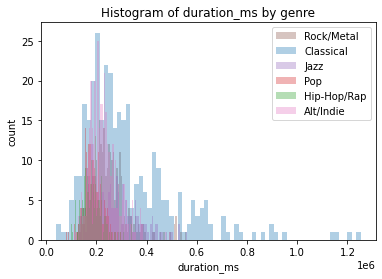

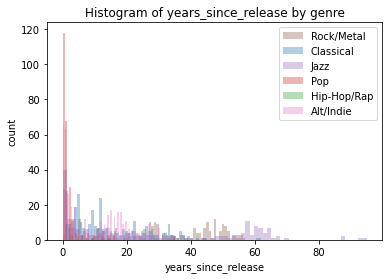

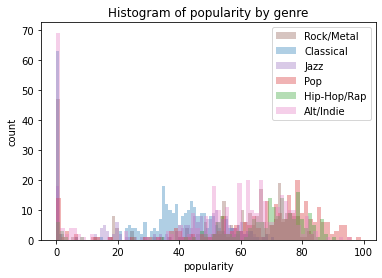

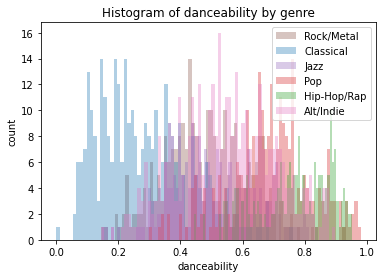

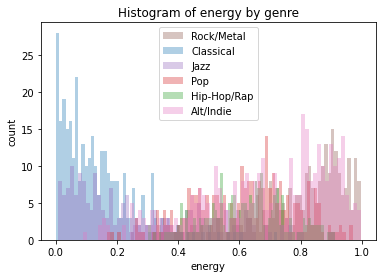

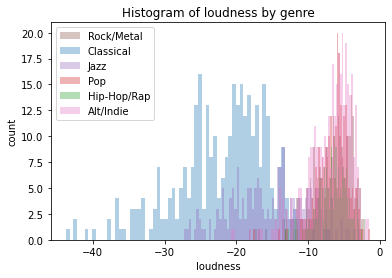

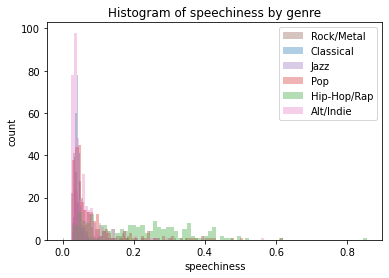

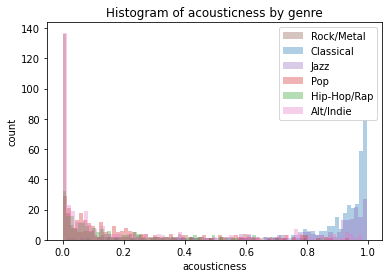

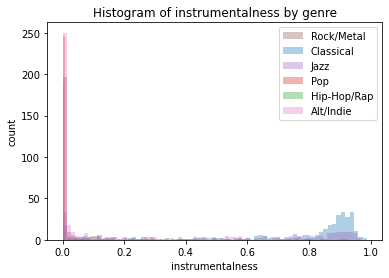

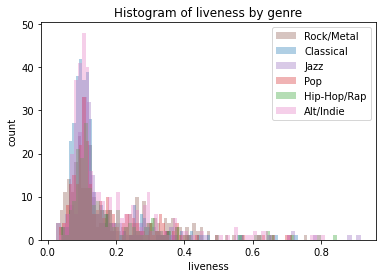

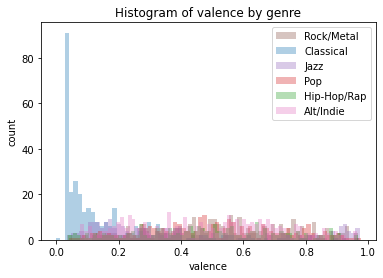

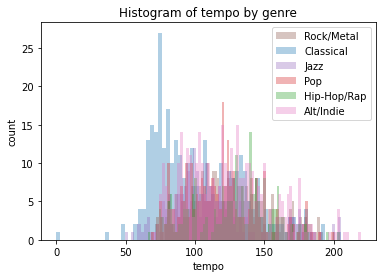

In [12]:
ALPHA = 0.35
def plot_feature_hist(pop_examples, hip_hop_examples, alt_ind_examples,
                      rock_examples, jazz_examples, classical_examples,
                      feature):
    plt.hist(rock_examples[feature], bins=70, color='tab:brown', label='Rock/Metal', alpha=ALPHA)
    plt.hist(classical_examples[feature], bins=70, color='tab:blue', label='Classical', alpha=ALPHA)
    plt.hist(jazz_examples[feature], bins=70, color='tab:purple', label='Jazz', alpha=ALPHA)
    plt.hist(pop_examples[feature], bins=70, color='tab:red', label='Pop', alpha=ALPHA)
    plt.hist(hip_hop_examples[feature], bins=70, color='tab:green', label='Hip-Hop/Rap', alpha=ALPHA)
    plt.hist(alt_ind_examples[feature], bins=70, color='tab:pink', label='Alt/Indie', alpha=ALPHA)
    plt.xlabel(feature)
    plt.ylabel('count')
    plt.title('Histogram of ' + feature + ' by genre')
    plt.legend(loc='best') 

for f in features:
    plot_feature_hist(pop_examples, hip_hop_examples, alt_ind_examples,
                      rock_examples, jazz_examples, classical_examples,
                      f)
    plt.show()

### Preprocessing ⏳

To prepare our data for supervised learning, we preprocess certain features and ensure the data has been transformed successfully.

In particular, we want to scale numeric features with `StandardScaler` to ensure differences in magnitude do not affect the model. This might be unnecessary for certain features that are already quie small (between 0 and 1) but is good practice nonetheless.

We also want to use `CountVectorizer` to count occurrances of key words in the `artist_genres` feature, as they are likely helpful in categorizing the true genre of the track.
* `max_features`: The maximum number of words to vectorize
* `stop_words`: Ignore-list of words

`ColumnTransformer` allows us to perform these transformation steps side-by-side, while passing through the remaining features.

In [13]:
preproc = ColumnTransformer([
    ('text', CountVectorizer(max_features=20, stop_words='english'), 'artist_genres'),
    ('scale', StandardScaler(), scale_features)
], remainder='passthrough')

preproc.fit(X_train)
cols_from_text = ['artist_genres_' + word for word in preproc.named_transformers_['text'].get_feature_names()]
X_train_preproc = pd.DataFrame(data=preproc.transform(X_train), columns=cols_from_text+scale_features+passthrough_features)
X_train_preproc.head()

,artist_genres_alternative,artist_genres_baroque,artist_genres_canadian,artist_genres_classical,artist_genres_dance,artist_genres_era,artist_genres_hip,artist_genres_hop,artist_genres_indie,artist_genres_jazz,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,explicit,key,mode,time_signature
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.723587,-0.968270,-0.681123,1.084382,0.346037,0.526238,1.0,2.0,1.0,4.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,-0.574383,1.206037,1.921831,-0.538384,-1.028049,0.996768,0.0,0.0,1.0,4.0
2,3.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,...,-0.214860,-0.999397,-0.670168,0.661052,-0.462472,0.561173,0.0,5.0,0.0,4.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.198830,-0.005714,-0.681116,-0.420793,0.699049,-0.895175,0.0,7.0,1.0,4.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.008411,-0.997800,-0.542189,0.904074,0.277713,2.015839,1.0,1.0,1.0,4.0


### Candidate Models ⚛

#### Dummy Classifier

A classifier that naively picks the most popular class.

In [14]:
y_train.value_counts()

2    374
5    330
3    268
0    260
4    194
1    194
Name: genre, dtype: int64

In this case, `DummyClassifier` will always predict class 2, which represents ~23% of the training data.

In [15]:
dc = DummyClassifier(strategy='prior')
dc_pipe = Pipeline([('preproc', preproc),
                    ('dc', dc)])
print(f'Cross-validation Score: {cross_validate(dc_pipe, X_train, y_train, return_train_score=True)["test_score"].mean()}')

Cross-validation Score: 0.2308641975308642


#### Logistic Regression

A basic linear classifier, where `max_iter` represents the maximum number of iterations of gradient descent allowed.

In [16]:
lr = LogisticRegression(max_iter=10000)
lr_pipe = Pipeline([('preproc', preproc),
                    ('lr', lr)])
print(f'Cross-validation Score: {cross_validate(lr_pipe, X_train, y_train, return_train_score=True)["test_score"].mean()}')

Cross-validation Score: 0.8487654320987653


#### LGBM Classifier

A gradient-boosting algorithm that grows trees leaf-wise instead of level-wise, good for large datasets and fast computations.

In [17]:
lgbm = LGBMClassifier(random_state=123)
lgbm_pipe = Pipeline([('preproc', preproc),
                      ('lgbm', lgbm)])
print(f'Cross-validation Score: {cross_validate(lgbm_pipe, X_train, y_train, return_train_score=True)["test_score"].mean()}')

Cross-validation Score: 0.8537037037037039


#### Random Forest Classifier

An ensemble algorithm that takes the majority vote of randomly trained decision trees.

In [18]:
rf = RandomForestClassifier(random_state=123, n_jobs=-1)
rf_pipe = Pipeline([('preproc', preproc),
                    ('rf', rf)])
print(f'Cross-validation Score: {cross_validate(rf_pipe, X_train, y_train, return_train_score=True)["test_score"].mean()}')

Cross-validation Score: 0.8629629629629629


### Hyperparameter Tuning 🎛

Let's choose the Random Forest Classifier to optimize, since it takes advantage of decision trees (which can capture non-linear trends), and had quite a high cross-validation accuracy (although it is dubious whether this is significant). We'll look at three parameters:
* `rf__n_estimators`: The number of decision trees in the forest
* `rf__max_depth`: The maximum depth of a decision tree
* `preproc__text__max_features`: The max number of features added by the `CountVectorizer`

#### Grid Search

A searcher that searches each unique possible combination of a fixed parameter grid.

In [19]:
params = {
    'rf__n_estimators' : [1, 2, 4, 8, 16, 32, 64, 128, 264],
    'rf__max_depth': [1, 2, 4, 8, 16, 32, 64],
    'preproc__text__max_features': [10, 15, 20]
}

grid_search = GridSearchCV(rf_pipe, params, verbose=2, n_jobs=-1, cv=10)

grid_search.fit(X_train, y_train)
pd.DataFrame(grid_search.cv_results_)[['mean_test_score', 'std_test_score', 'param_rf__n_estimators', 'param_rf__max_depth', 'param_preproc__text__max_features', 'mean_fit_time', 'rank_test_score']].set_index('rank_test_score').sort_index().head(10)

Fitting 10 folds for each of 189 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   35.5s finished


,mean_test_score,std_test_score,param_rf__n_estimators,param_rf__max_depth,param_preproc__text__max_features,mean_fit_time
rank_test_score,,,,,,
1,0.869136,0.022393,128,8,15,0.429000
2,0.866049,0.026196,264,8,20,0.878001
3,0.865432,0.025719,264,64,20,0.901900
3,0.865432,0.025719,264,32,20,0.972901
5,0.864815,0.020924,64,8,15,0.240700
6,0.864198,0.022427,264,32,15,0.916100
6,0.864198,0.022427,264,64,15,0.960600
6,0.864198,0.018312,128,8,20,0.439100
9,0.863580,0.022503,264,8,15,0.869200


#### Random Search

A searcher that randomly chooses combinations given a set of parameters to optimize.

In [20]:
params = {
    'rf__n_estimators' : np.arange(1, 300),
    'rf__max_depth' : np.arange(1, 64),
    'preproc__text__max_features': np.arange(10, 20)
}

random_search = RandomizedSearchCV(rf_pipe, params, n_iter = 120, verbose = 1, n_jobs = -1, cv=10, random_state = 123)

random_search.fit(X_train, y_train)
pd.DataFrame(random_search.cv_results_)[['mean_test_score', 'std_test_score', 'param_rf__n_estimators', 'param_rf__max_depth', 'param_preproc__text__max_features', 'mean_fit_time', 'rank_test_score']].set_index('rank_test_score').sort_index().head(10)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   50.5s finished


,mean_test_score,std_test_score,param_rf__n_estimators,param_rf__max_depth,param_preproc__text__max_features,mean_fit_time
rank_test_score,,,,,,
1,0.866667,0.021060,192,20,19,0.609900
2,0.866049,0.021392,213,62,14,0.923100
3,0.866049,0.019724,236,57,17,0.783698
3,0.866049,0.020107,205,57,19,0.748699
5,0.865432,0.026878,250,59,12,0.949100
5,0.865432,0.022222,184,40,19,0.834100
5,0.865432,0.026160,234,22,12,0.982400
5,0.865432,0.023554,186,31,15,0.745800
5,0.865432,0.019086,226,9,18,0.810199


### Feature Importances 📊

Feature importances in Random Forests represent the average decrease in gini impurity across all features across all trees. Gini impurity represents the probability of randomly picking a datapoint, randomly classifying it according to the distribution in the dataset, and the subsequent probability of classifying it incorrectly.

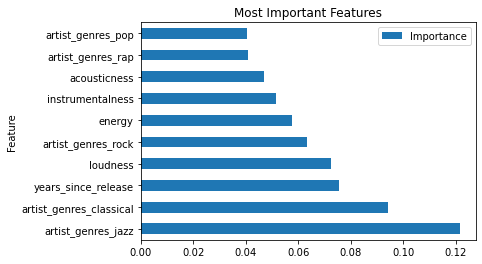

In [21]:
estimator = grid_search.best_estimator_
estimator['preproc'].fit(X_train)
cols_from_text = ['artist_genres_' + word for word in estimator['preproc'].named_transformers_['text'].get_feature_names()]
features = cols_from_text+scale_features+passthrough_features
estimator.fit(X_train, y_train)
importances = pd.DataFrame({'Importance':estimator['rf'].feature_importances_,'Feature':features}).sort_values(by="Importance",ascending=False)
top_ten_importances = importances[0:10]
top_ten_importances.plot.barh(x='Feature', y='Importance', title='Most Important Features');

### Evaluation 🏁

#### Test Results

We can classify genres to ~90% accuracy on test data, much improved from the naive ~23% of `DummyClassifier`.

In [22]:
estimator.fit(X_train, y_train)
test_score = estimator.score(X_test, y_test)
print(f'Final score on test data: {test_score}')

Final score on test data: 0.8990147783251231


#### Alternative Metrics

However, we should also consider alternative metrics, namely:
* `precision`: TP/(TP+FP) - Of the classified positives, how many were actually positive?
* `recall`: TP/(TP+FN) - What % of positive examples were correctly identified?
* `f1`: 2 \* (precision \* recall) / (precision + recall)

In [23]:
print(classification_report(y_test, estimator.predict(X_test), target_names=GENRES.keys()))

              precision    recall  f1-score   support

         Pop       0.94      0.77      0.85        65
 Hip-Hop-Rap       0.92      1.00      0.96        49
   Alt-Indie       0.81      0.84      0.83        94
        Rock       0.86      0.90      0.88        67
        Jazz       0.94      0.98      0.96        49
   Classical       0.96      0.96      0.96        82

    accuracy                           0.90       406
   macro avg       0.91      0.91      0.91       406
weighted avg       0.90      0.90      0.90       406



Ultimately, it seems like our model performs quite well for all genres across all metrics; a marked improvement from the `DummyClassifier` baseline.

#### Future Improvements

1. Better Data
 * Gather data from more playlists for each genre
 * Add new genres to be classified
 * Gather more granular audio information from the Spotify API
2. Better Models
 * More careful feature engineering
 * Try more classifiers, look at deep learning if enough data
 * Optimize more than one classifier, spend more time training, use more powerful hardware
3. Better Analysis
 * Visualize train/validation scores
 * Identify feature importances through SHAP values and analysis
 * Visualize confusion matrix
 * Use additional scoring metrics like Precision-Recall curves with average precision, and ROC curves with AUC
4. Better Code
 * Refactor initial preprocessing into the preprocessing pipeline
 * Restructure into OOP
 * Write unit tests, especially to test downloader
 
(Ultimately) Better Integration: convert data science back-end into web app for users to classify their liked songs